<a href="https://colab.research.google.com/github/Sandeephm/GoogleColab-codes/blob/master/Cats_vs_Dogs_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Download the classifier

Download the MobileNet model and create a Keras model from it.
MobileNet is expecting images of 224 $\times$ 224 pixels, in 3 color channels (RGB).

In [0]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

65536/61306 [================================] - 0s 0us/step


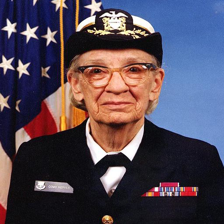

In [0]:
# Run it on a single image

import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [0]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [0]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [0]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

16384/10484 [==============================================] - 0s 0us/step


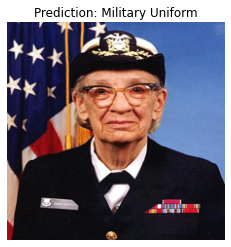

In [0]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# Dataset

In [0]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete9OU5SR/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [0]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [0]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

Run the classifier on a batch of image

In [0]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Egyptian cat', 'tiger cat', 'German shepherd', 'Egyptian cat',
       'dingo', 'Chesapeake Bay retriever', 'Staffordshire bullterrier',
       'American Staffordshire terrier', 'miniature schnauzer', 'kelpie',
       'miniature pinscher', 'redbone', 'Labrador retriever', 'Pembroke',
       'Rhodesian ridgeback', 'Siamese cat', 'tabby', 'Siamese cat',
       'cocker spaniel', 'American Staffordshire terrier', 'kelpie',
       'flat-coated retriever', 'Persian cat', 'Persian cat', 'tabby',
       'Siamese cat', 'redbone', 'tabby', 'tabby', 'chow', 'Leonberg',
       'Labrador retriever'], dtype='<U30')

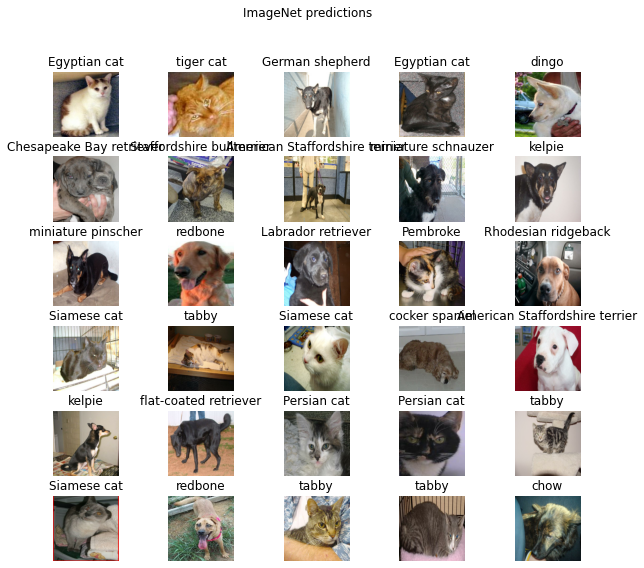

In [0]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# Re Train MobileNet

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

feature_extractor.trainable = False

(32, 1280)


Attach a classification head

In [0]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 32s 55ms/step - loss: 0.0531 - accuracy: 0.9817 - val_loss: 0.0320 - val_accuracy: 0.9888
Epoch 2/6
582/582 [==============================] - 32s 54ms/step - loss: 0.0295 - accuracy: 0.9900 - val_loss: 0.0312 - val_accuracy: 0.9899
Epoch 3/6
582/582 [==============================] - 33s 56ms/step - loss: 0.0239 - accuracy: 0.9924 - val_loss: 0.0297 - val_accuracy: 0.9903
Epoch 4/6
582/582 [==============================] - 32s 56ms/step - loss: 0.0206 - accuracy: 0.9929 - val_loss: 0.0303 - val_accuracy: 0.9895
Epoch 5/6
582/582 [==============================] - 32s 55ms/step - loss: 0.0193 - accuracy: 0.9939 - val_loss: 0.0332 - val_accuracy: 0.9888
Epoch 6/6
582/582 [==============================] - 31s 54ms/step - loss: 0.0173 - accuracy: 0.9938 - val_loss: 0.0359 - val_accuracy: 0.9888


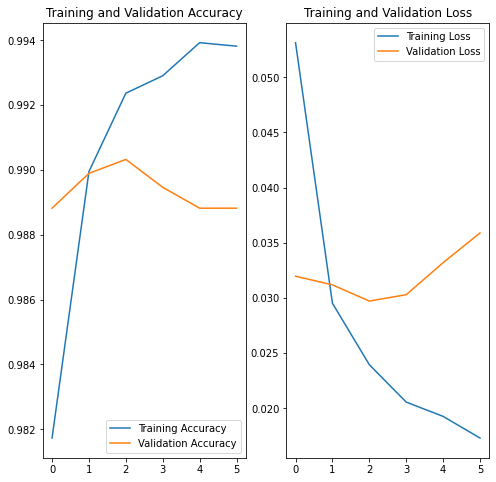

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Test the model

In [0]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [0]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog',
       'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat',
       'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog',
       'cat', 'cat', 'dog', 'dog', 'dog'], dtype='<U3')

In [0]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 1]
Predicted labels:  [0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 1]


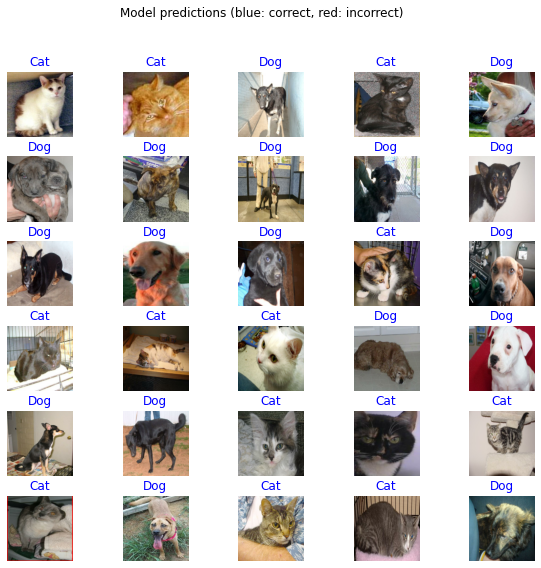

In [0]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")